# **Huấn luyện Mô hình CNN**
##**Mục tiêu**
- Xây dựng và huấn luyện mô hình **Convolutional Neural Network (CNN)** để phân loại ảnh trong tập dữ liệu **CIFAR-10**.
- Thực hiện các bước:
  - Tiền xử lý dữ liệu.
  - Tăng cường dữ liệu (*Data Augmentation*).
  - Huấn luyện mô hình qua nhiều epoch.
  - Đánh giá hiệu suất mô hình bằng các chỉ số quan trọng như **Loss(Hàm mất mát)**, **Accuracy(Độ chính xác)**, và **Confusion Matrix(Ma trận nhầm lẫn)**.
- Trực quan hóa quá trình huấn luyện qua biểu đồ.


## **Cấu hình Google Colab với GPU**

- Truy cập vào menu **Runtime** (Thời gian chạy).
- Chọn **Change runtime type** (Thay đổi kiểu môi trường).
- Trong mục **Hardware accelerator** (Trình tăng tốc phần cứng), chọn: **T4 GPU**.
- Nhấn nút **Save** (Lưu) để lưu thay đổi.



## **1. Chuẩn bị môi trường**



### **1.1. Cài đặt các thư viện cần thiết**
- **TensorFlow**: Framework chính để xây dựng và huấn luyện mô hình CNN.
- **Keras**: API cấp cao trong TensorFlow để xây dựng mô hình nhanh chóng.
- **Matplotlib** và **Seaborn**: Công cụ trực quan hóa dữ liệu và biểu đồ.
- **Scikit-learn**: Hỗ trợ tính toán các chỉ số như Confusion Matrix và Classification Report.

In [ ]:
!pip install tensorflow seaborn matplotlib scikit-learn keras

### **1.2. Import các thư viện**




In [ ]:
# Import thư viện
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import json
%matplotlib inline

## **2. Dữ liệu CIFAR-10**

### **2.1. Tải tập dữ liệu**

In [ ]:
# Tải tập dữ liệu CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Phân chia tập huấn luyện và tập kiểm tra
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


### **2.2. Phân phối dữ liệu**

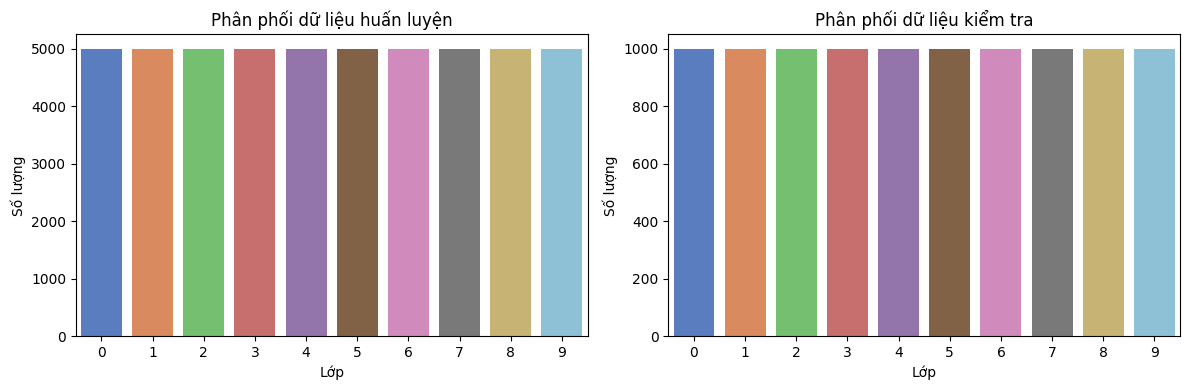

In [ ]:
# Định nghĩa số lượng lớp
num_classes = 10

# Tính số lượng ảnh mỗi lớp trong tập train và test
train_counts = [sum(y_train.flatten() == i) for i in range(num_classes)]
test_counts = [sum(y_test.flatten() == i) for i in range(num_classes)]

# Tạo biểu đồ có hai cột
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Biểu đồ phân phối tập huấn luyện
sns.barplot(x=list(range(num_classes)), y=train_counts, ax=axs[0],
            palette="muted", hue=list(range(num_classes)), legend=False)
axs[0].set_title("Phân phối dữ liệu huấn luyện")
axs[0].set_xlabel("Lớp")
axs[0].set_ylabel("Số lượng")

# Biểu đồ phân phối tập kiểm tra
sns.barplot(x=list(range(num_classes)), y=test_counts, ax=axs[1],
            palette="muted", hue=list(range(num_classes)), legend=False)
axs[1].set_title("Phân phối dữ liệu kiểm tra")
axs[1].set_xlabel("Lớp")
axs[1].set_ylabel("Số lượng")

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


### **2.3. Chuẩn hóa dữ liệu**
- Ảnh được chuẩn hóa về khoảng giá trị [0, 1] bằng cách chia mỗi pixel cho 255.
- Các nhãn ảnh được chuyển đổi sang dạng **One Hot Encoding** để phù hợp với đầu ra của mô hình CNN.
- Kích thước batch (32) và số lượng epoch (100) được thiết lập cho quá trình huấn luyện.

In [ ]:
# Chuẩn hóa dữ liệu.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Chuyển đổi vectơ lớp thành ma trận lớp nhị phân. One Hot Encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

batch_size = 32 # Batch size mặc định
epochs = 100 # Số lần huấn luyện

## **3. Xây dựng kiến trúc mô hình CNN**

In [ ]:
# Định nghĩa mô hình CNN
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.001), input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(512, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 15, 15, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 13, 13, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 6, 6, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 6, 6, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 6, 6, 128)           │              

 Total params: 1,107,594 (4.23 MB)

 Trainable params: 1,105,226 (4.22 MB)

 Non-trainable params: 2,368 (9.25 KB)

### **3.1 Cấu hình trình tối ưu hóa và compile mô hình**

In [ ]:
# khởi động trình tối ưu hóa RMSprop
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

# Huấn luyện mô hình bằng RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

### **3.2 Tăng cường dữ liệu**

In [ ]:
data_augmentation = True # Bật tăng cường dữ liệu

if not data_augmentation:
    print('Không sử dụng tăng cường dữ liệu.')
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        shuffle=True)
else:
    print('Sử dụng tăng cường dữ liệu.')
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=5,  # Xoay ngẫu nhiên trong khoảng 5 độ
        width_shift_range=0.05,  # Dịch ngang ngẫu nhiên 5% chiều rộng ảnh
        height_shift_range=0.05,  # Dịch dọc ngẫu nhiên 5% chiều cao ảnh
        shear_range=0.05,  # Thêm biến dạng hình học
        zoom_range=0.05,  # Phóng to hoặc thu nhỏ ngẫu nhiên
        channel_shift_range=0.,  # Dịch chuyển kênh màu
        fill_mode='nearest',
        rescale=None,
        cval=0.,
        horizontal_flip=True,  # Lật ảnh theo chiều ngang
        vertical_flip=False,  # Không lật ảnh theo chiều dọc
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0
    )
    # Tính toán thông số cần thiết cho chuẩn hóa dựa trên dữ liệu huấn luyện
    datagen.fit(x_train)

Sử dụng tăng cường dữ liệu.


### **3.3 Hiển thị ảnh trước và sau khi tăng cường dữ liệu**

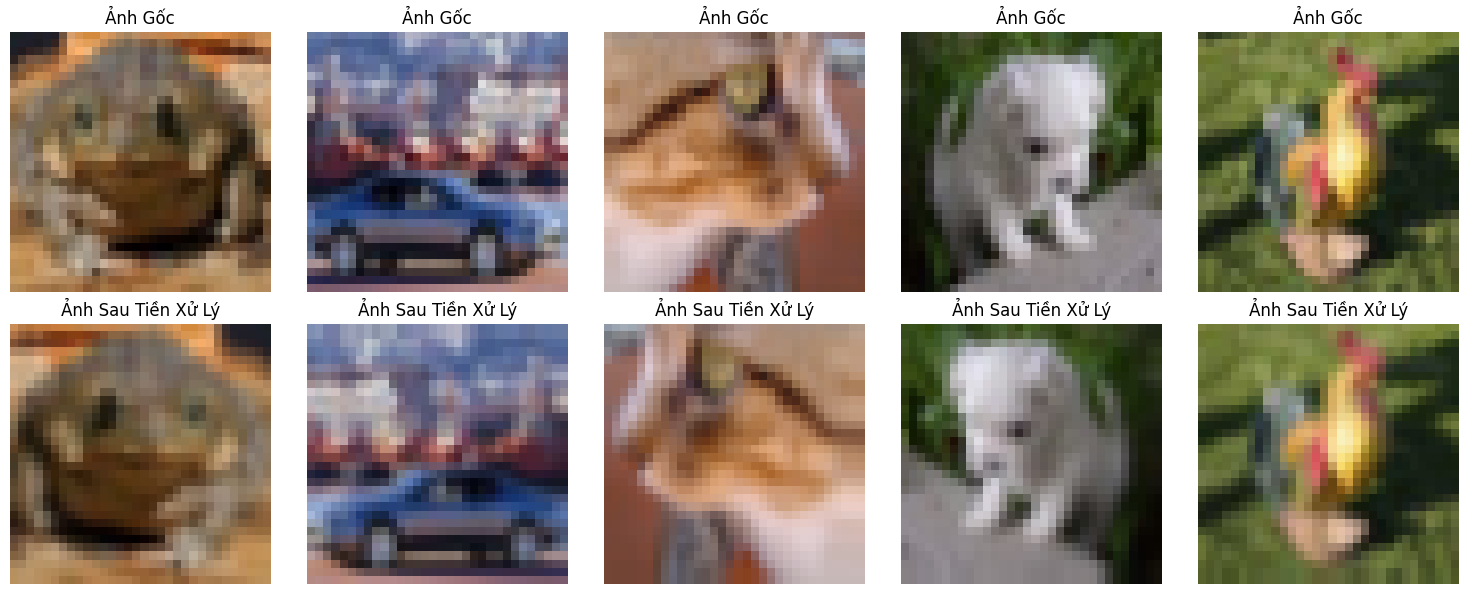

In [ ]:
# Hiển thị ảnh gốc và ảnh sau khi augmentation (tiền xử lý)
import matplotlib.pyplot as plt

# Lấy mẫu ảnh gốc từ x_train
num_samples = 5  # Số lượng ảnh cần hiển thị
indices = np.random.choice(range(x_train.shape[0]), num_samples, replace=False)

fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

# Hiển thị ảnh gốc
for i, idx in enumerate(indices):
    axes[0, i].imshow(x_train[idx])
    axes[0, i].axis('off')
    axes[0, i].set_title("Ảnh Gốc")

augmented_images = [datagen.random_transform(x_train[idx]) for idx in indices]

# Hiển thị ảnh sau khi augmentation
for i, img in enumerate(augmented_images):
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title("Ảnh Sau Tiền Xử Lý")

plt.tight_layout()
plt.show()

def plotmodelhistory(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # history của độ chính xác
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # history của hàm mất mát
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

### **3.4 Khởi tạo callback và bắt đầu huấn luyện**

In [ ]:
    # Khởi tạo callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
    # Huấn luyện mô hình với dữ liệu được tăng cường
    history = model.fit(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test))

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 68s 36ms/step - accuracy: 0.2692 - loss: 3.2869 - val_accuracy: 0.4812 - val_loss: 2.5798
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 29ms/step - accuracy: 0.4644 - loss: 2.5898 - val_accuracy: 0.4876 - val_loss: 2.4786
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.5392 - loss: 2.3016 - val_accuracy: 0.5057 - val_loss: 2.5576
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.5943 - loss: 2.0615 - val_accuracy: 0.6299 - val_loss: 1.9213
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step - accuracy: 0.6339 - loss: 1.8549 - val_accuracy: 0.6408 - val_loss: 1.7950
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.6674 - loss: 1.6914 - val_accuracy: 0.6191 - val_loss: 1.8586
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 28ms/step - accuracy: 0.6914 - loss: 1.5574 - val_accuracy: 0.6939 - val_loss: 1.5359
Epoch 8/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.7068 - los

## **4. Kết quả huấn luyện**

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


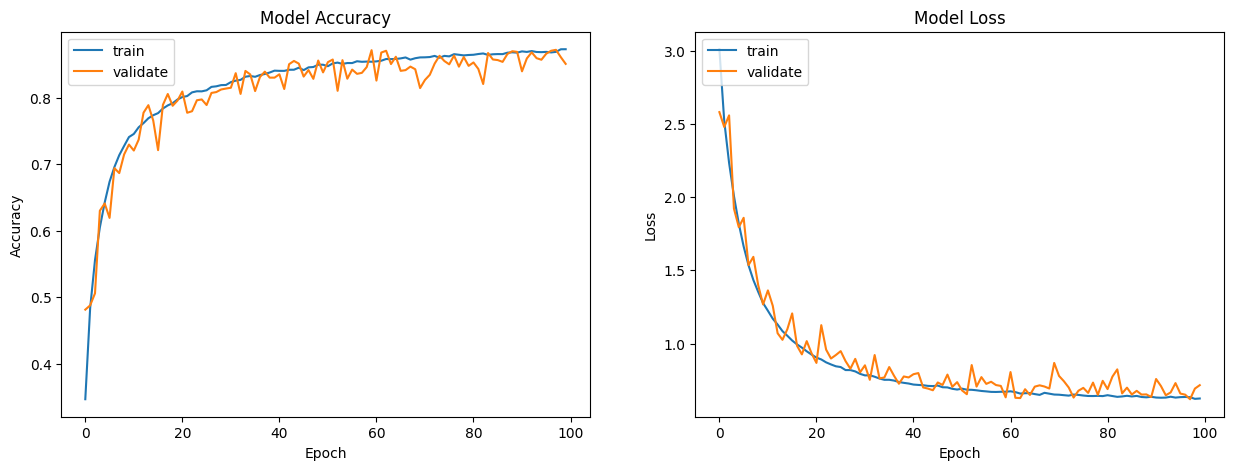

In [ ]:
# danh sách tất cả dữ liệu của history
print(history.history.keys())

plotmodelhistory(history)

### **4.1 Thông số Accuracy và Loss**

In [ ]:
# in ra độ chính xác và hàm mất mát của mô hình sau khi huấn luyện
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8498 - loss: 0.7164
Test loss: 0.7166112065315247
Test accuracy: 0.8507000207901001


### **4.2 Ma trận nhầm lẫn**

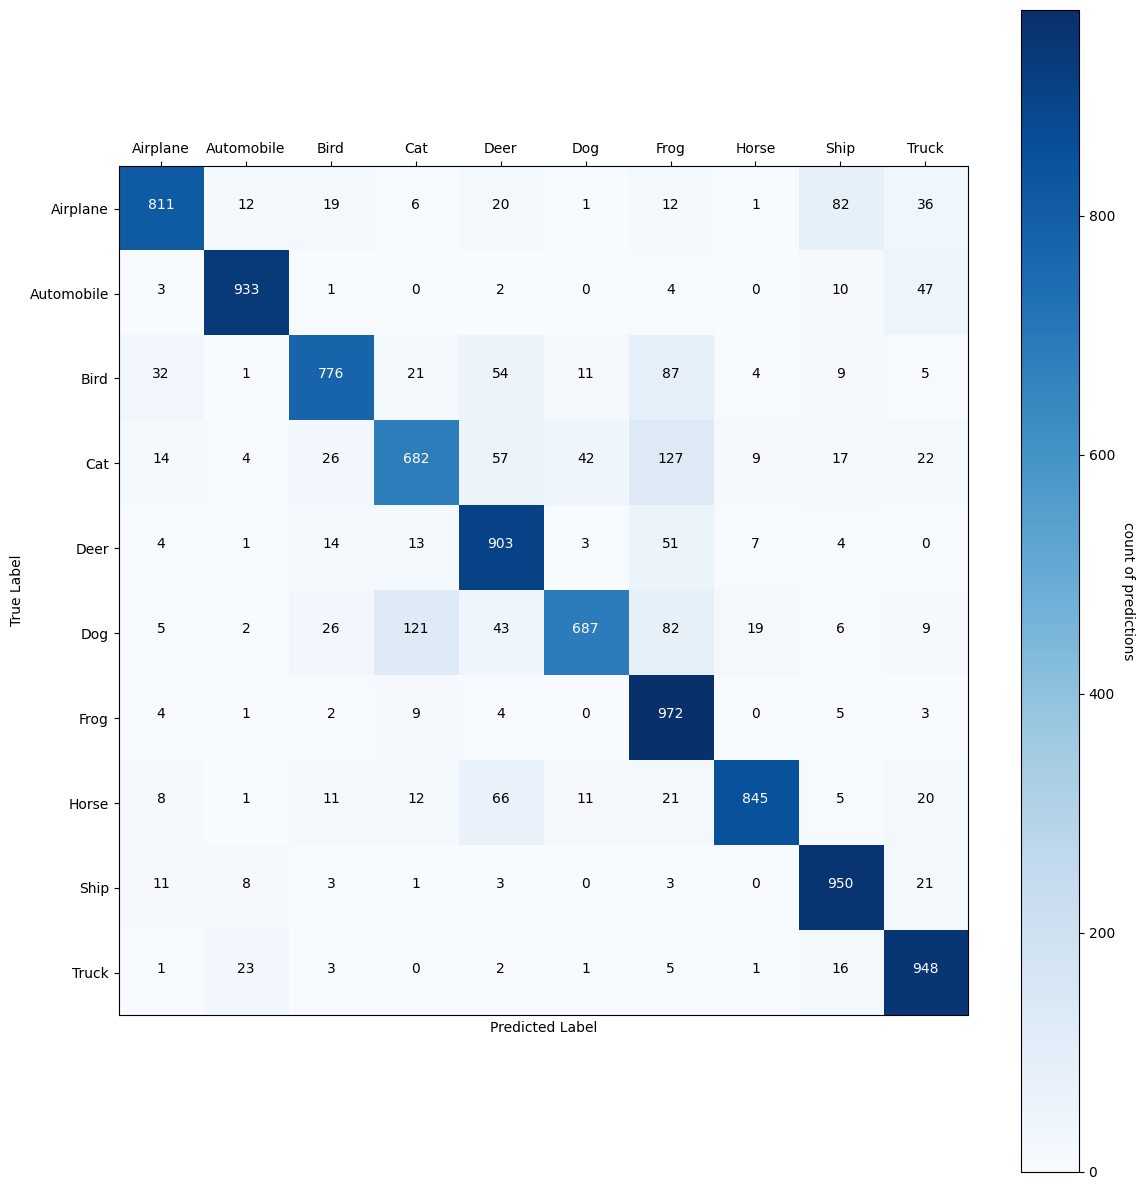

In [ ]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

Y_pred_classes = np.argmax(pred, axis=1)
Y_true = np.argmax(y_test, axis=1)
# Lỗi là sự khác biệt giữa nhãn dự đoán và nhãn thực
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes)
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()


In [ ]:
# đưa ra dự đoán
pred = model.predict(x_test)

def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
   Tạo một biểu đồ nhiệt từ một mảng numpy và hai danh sách nhãn
    """
    if not ax:
        ax = plt.gca()

    # Vẽ biểu đồ nhiệt
    im = ax.imshow(data, **kwargs)

    # Tạo thanh màu
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # show all ticks..
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # gắn nhãn với các mục danh sách tương ứng.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    Một hàm để chú thích biểu đồ nhiệt
    """
    # Thay đổi màu tùy thuộc vào dữ liệu.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


### **4.3 Báo cáo đánh giá hiệu xuất mô hình**

In [ ]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      1000
           1       0.95      0.93      0.94      1000
           2       0.88      0.78      0.83      1000
           3       0.79      0.68      0.73      1000
           4       0.78      0.90      0.84      1000
           5       0.91      0.69      0.78      1000
           6       0.71      0.97      0.82      1000
           7       0.95      0.84      0.90      1000
           8       0.86      0.95      0.90      1000
           9       0.85      0.95      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



## **5. Dự đoán ảnh trên tập kiểm tra**

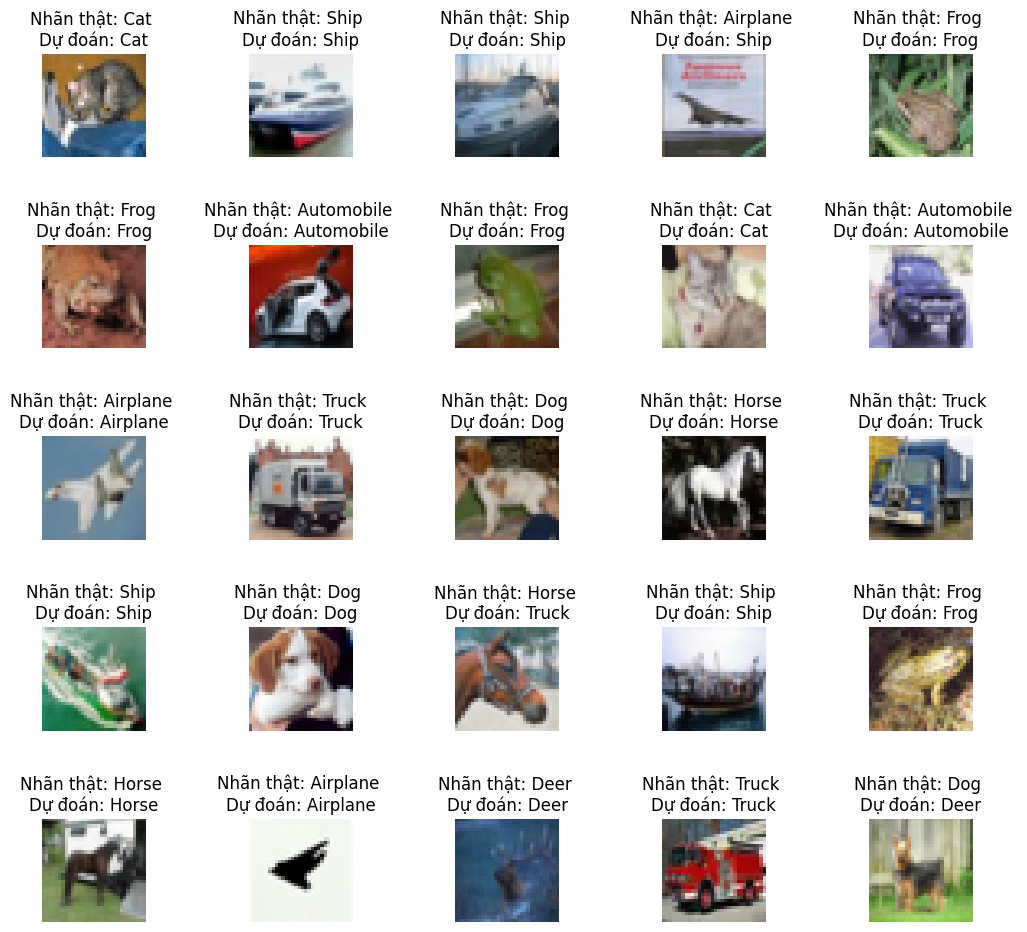

In [ ]:
# Dự đoán
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(0, R * C):
    confidence = pred[i][Y_pred_classes[i]]
    axes[i].imshow(x_test[i])
    axes[i].set_title("Nhãn thật: %s \nDự đoán: %s" % (
        labels[Y_true[i]],
        labels[Y_pred_classes[i]],
       ))
    axes[i].axis('off')

plt.subplots_adjust(wspace=1)
plt.show()

### **5.1 Các dự đoán sai**

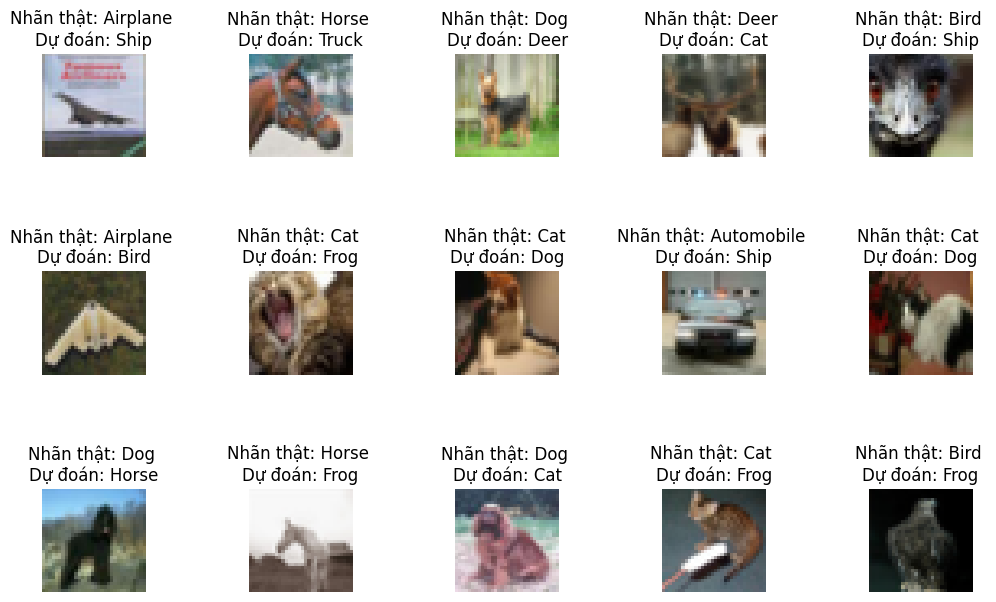

In [ ]:
R = 3
C = 5
fig, axes = plt.subplots(R, C, figsize=(12, 8))
axes = axes.ravel()

# Chỉ số các dự đoán sai
misclassified_idx = np.where(Y_pred_classes != Y_true)[0]

# Lặp qua các dự đoán sai
for i in np.arange(0, R * C):
    # Lấy chỉ số lỗi
    idx = misclassified_idx[i]

    # Hiển thị hình ảnh
    axes[i].imshow(x_test[idx])
    axes[i].set_title("Nhãn thật: %s \nDự đoán: %s" % (
        labels[Y_true[idx]],
        labels[Y_pred_classes[idx]]
    ))
    axes[i].axis('off')

plt.subplots_adjust(wspace=1)
plt.show()

### **5.2 Các dự đoán sai nghiêm trọng nhất**

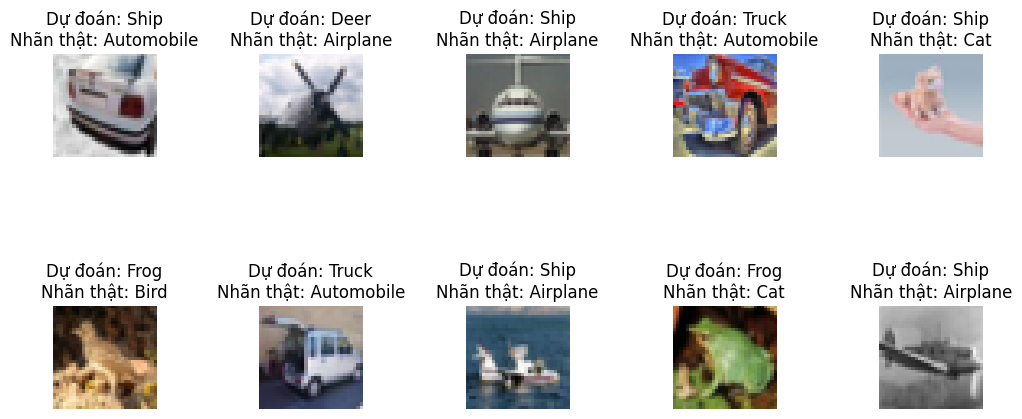

In [ ]:
# Kiểm tra các lỗi quan trọng nhất
def display_errors(errors_index, img_errors, pred_errors, obs_errors, pred_probs):
    """ Chức năng này hiển thị 10 hình ảnh có nhãn thật, nhãn dự đoán và xác suất dự đoán """
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12, 6))

    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]  # Lấy chỉ số của lỗi
            ax[row, col].imshow((img_errors[error]).reshape((32, 32, 3)))

            # Xác suất dự đoán của lớp dự đoán
            confidence = pred_probs[error]

            ax[row, col].set_title("Dự đoán: {}\nNhãn thật: {}".format(
                labels[pred_errors[error]],
                labels[obs_errors[error]],
                ))
            n += 1
            ax[row, col].axis('off')
            plt.subplots_adjust(wspace=1)

# Xác suất của các số dự đoán sai
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)

# Xác suất dự đoán của các giá trị thực trong tập lỗi
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Sự khác biệt giữa xác suất của nhãn dự đoán và nhãn thực
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Danh sách sắp xếp các lỗi
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# 10 lỗi hàng đầu
most_important_errors = sorted_dela_errors[-10:]

# Hiển thị 10 lỗi hàng đầu với xác suất dự đoán
display_errors(most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors, Y_pred_errors_prob)



### **5.3 Dự đoán ảnh với lớp có xác xuất cao nhất**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


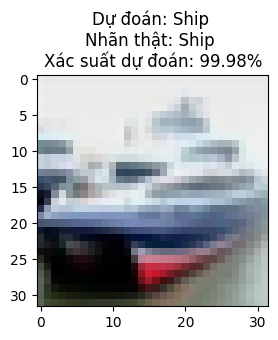

In [ ]:
# Kiểm thử mô hình với các ảnh kiểm thử trong bộ kiểm thử.
def show_test(number):
    fig = plt.figure(figsize=(3, 3))

    # Lấy một hình ảnh từ tập kiểm tra và mở rộng chiều để phù hợp với đầu vào của mô hình
    test_image = np.expand_dims(x_test[number], axis=0)

    # Dự đoán lớp với xác suất, sau đó chuyển đổi xác suất thành lớp
    test_result = model.predict(test_image)
    dict_key = np.argmax(test_result, axis=1)[0]  # Chọn lớp có xác suất cao nhất
    confidence = test_result[0][dict_key]  # Lấy xác suất dự đoán của lớp được chọn

    # Vẽ hình ảnh và hiển thị nhãn dự đoán, nhãn thực tế, và xác suất
    plt.imshow(x_test[number])
    plt.title("Dự đoán: {} \nNhãn thật: {} \nXác suất dự đoán: {:.2f}%".format(
        labels[dict_key],
        labels[np.argmax(y_test[number])],
        confidence * 100))
    plt.show()

show_test(1)

### **5.4 Lưu mô hình**

In [ ]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.keras'

# Tạo thư mục nếu chưa tồn tại
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

# Đường dẫn đầy đủ để lưu mô hình
model_path = os.path.join(save_dir, model_name)

# Lưu mô hình vào tệp .keras
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Đánh giá mô hình trên tập kiểm tra
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /content/saved_models/keras_cifar10_trained_model.keras 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8498 - loss: 0.7164
Test loss: 0.7166112065315247
Test accuracy: 0.8507000207901001


### **5.5 Dự đoán ảnh ngoài tập dữ liệu**

In [ ]:
# Tải mô hình đã huấn luyện
model_path = "saved_models/keras_cifar10_trained_model.keras"
model = load_model(model_path)

# Danh sách các lớp (nhãn)
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Hàm dự đoán từ ảnh
def predict_image(model, img_path):
    """
    Dự đoán lớp từ ảnh đầu vào.
    Args:
        model: Mô hình đã huấn luyện.
        img_path: Đường dẫn ảnh.
    Returns:
        original_image: Ảnh gốc (PIL Image).
        processed_image: Ảnh đã chuẩn hóa (numpy array).
        predicted_index: Chỉ số lớp dự đoán.
        predicted_class: Tên lớp dự đoán.
    """
    # Tải ảnh gốc
    original_image = image.load_img(img_path)  # Giữ nguyên kích thước gốc
    # Resize ảnh để phù hợp với mô hình
    resized_image = original_image.resize((32, 32))
    img_array = image.img_to_array(resized_image)  # Chuyển ảnh thành numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Mở rộng chiều batch
    img_array = img_array / 255.0  # Chuẩn hóa giá trị pixel

    # Dự đoán
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions, axis=1)[0]  # Lấy lớp có xác suất cao nhất
    predicted_class = labels[predicted_index]  # Lấy tên lớp từ danh sách labels

    return original_image, img_array.shape, predicted_index, predicted_class


# Hàm xử lý khi tải ảnh
def on_file_upload(change):
    uploaded_file = next(iter(change['new'].values()))  # Lấy file ảnh tải lên
    image_path = uploaded_file['metadata']['name']
    with open(image_path, 'wb') as f:
        f.write(uploaded_file['content'])  # Lưu file ảnh

    # Hiển thị trạng thái "Đang tiến hành dự đoán..."
    loading_label.value = "<p style='font-size: 16px; color: #d32f2f;'>Đang tiến hành dự đoán...</p>"

    # Dự đoán kết quả
    original_image, processed_size, predicted_index, predicted_class = predict_image(model, image_path)

    # Chuyển ảnh gốc sang Base64 để hiển thị
    buffer_input = BytesIO()
    original_image.save(buffer_input, format="PNG")
    img_base64_input = base64.b64encode(buffer_input.getvalue()).decode("utf-8")

    # Hiển thị kết quả
    with output_widget:
        output_widget.clear_output()
        display(widgets.HTML(value=f"""
        <div style='
            display: flex;
            flex-direction: column;
            align-items: center;
            justify-content: center;
            border: 5px solid #1565c0;
            border-radius: 15px;
            padding: 25px;
            max-width: 500px;
            margin: 0 auto;
            background-color: #ffffff;'>

            <h2 style='color: #1565c0; font-size: 18px; text-align:center;'>Kết quả dự đoán</h2>
            <p style='font-size: 16px; color: #000000;'><b>Tên file ảnh:</b> {uploaded_file['metadata']['name']}</p>
            <p style='font-size: 16px; color: #000000;'><b>Kích thước gốc:</b> {original_image.size}</p>
            <p style='font-size: 16px; color: #000000;'><b>Kích thước sau chuẩn hóa:</b> {processed_size}</p>
            <p style='font-size: 16px; color: #000000;'><b>Lớp dự đoán:</b>
                <span style='color:#d32f2f; font-weight:bold;'>{predicted_class}</span>
            </p>
            <div style="display: flex; justify-content: center; align-items: center; margin-top: 15px;">
                <div style="margin-right: 15px; text-align: center;">
                    <p style="font-size: 16px; font-weight: bold; color: #1565c0;">Ảnh đầu vào</p>
                    <img src="data:image/png;base64,{img_base64_input}" alt="Ảnh đầu vào" style="max-width: 300px; max-height: 300px; border-radius: 10px; border: 1px solid #ccc;"/>
                </div>
            </div>
        </div>
        """))
    # Ẩn thông báo "Đang tiến hành dự đoán..."
    loading_label.value = ""


# Định nghĩa nhãn hiển thị trạng thái
loading_label = widgets.HTML(value="")

# Định nghĩa widget để hiển thị kết quả
output_widget = widgets.Output()

# Nút tải ảnh
upload_button = widgets.FileUpload(accept='image/*', multiple=False, description="Tải lên")
upload_button.observe(on_file_upload, names='value')

# Giao diện chính
interface = widgets.VBox([
    widgets.HTML(value="<h3 style='color: #1565c0; font-size: 16px; text-align:center; padding: 10px;'>Tải lên hình ảnh muốn dự đoán:</h3>"),
    widgets.HBox([upload_button], layout=widgets.Layout(justify_content='center', margin='0 0 20px 0')),
    loading_label,
    output_widget  # Thêm output_widget vào giao diện
])

# Hiển thị giao diện
display(interface)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
